# Предсказание стоимости автомобилей

Необходимо построить модель машинного обучения, которая сможет быстро, качественно подсказать клиенту рыночную стоимость автомобиля. Данная модель в дальнейшем будет интегрирована в приложение по продаже автомобилей с пробегом.

### Библиотеки и модули

In [114]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

### Содержание

1. Подготовка данных
    - Работа с пропусками
    - Работа с дубликатами
    - Работа с признаками
2. Обучение моделей
    - LGBMRegressor
    - CatBoostRegressor
3. Анализ моделей

## Подготовка данных

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
autos.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
gaps = autos.isnull().sum() / autos.shape[0] * 100
print(f'{gaps.sort_values(ascending=False)}')

NotRepaired          20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
LastSeen              0.000000
PostalCode            0.000000
NumberOfPictures      0.000000
DateCreated           0.000000
Brand                 0.000000
RegistrationMonth     0.000000
Kilometer             0.000000
Power                 0.000000
RegistrationYear      0.000000
Price                 0.000000
DateCrawled           0.000000
dtype: float64


Видим, что в данных присутствуют пропуски: в столбцах NotRepaired, VehicleType, FuelType, Gearbox, Model.

In [6]:
print(autos.columns.tolist())

['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']


In [7]:
new_columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

In [8]:
autos.columns = new_columns

### Работа с пропусками

In [9]:
raw_gaps = autos.query("not_repaired.isnull() == True and vehicle_type.isnull() == True and fuel_type.isnull() == True and gearbox.isnull() == True and model.isnull() == True")
raw_gaps.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
522,2016-03-14 18:40:14,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,2016-03-14 00:00:00,0,25524,2016-03-14 18:40:14
538,2016-03-15 17:43:21,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,NaN,2016-03-15 00:00:00,0,94315,2016-04-06 14:45:44
552,2016-03-21 10:52:52,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN,2016-03-21 00:00:00,0,69120,2016-03-22 14:50:41
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37


In [10]:
raw_gaps.shape[0]

2237

Предположим, что данные объекты являются просто выбросами, поскольку об этих машинах не указана важная информация о типе модели, коробке передач, мощности, о том, что за модель, о типе топлива, чинилась она или нет. В каких-то случаях даже не указана цена машины среди данных объетов, а также сомнительно, что отсутствуют фотографии машин. Удалим данные объекты из анализа и посмотрим, какой процент пропусков в признаках остался.

In [11]:
autos.drop(raw_gaps.index.tolist(), axis=0, inplace=True)

In [12]:
gaps = autos.isnull().sum() / autos.shape[0] * 100
print(f'{gaps.sort_values(ascending=False)}')

not_repaired          19.571354
vehicle_type          10.011303
fuel_type              8.706394
gearbox                4.996990
model                  4.960640
last_seen              0.000000
postal_code            0.000000
number_of_pictures     0.000000
date_created           0.000000
brand                  0.000000
registration_month     0.000000
kilometer              0.000000
power                  0.000000
registration_year      0.000000
price                  0.000000
date_crawled           0.000000
dtype: float64


Исключим из рассмотрения те машины, у которых указанная цена равна 0.

In [13]:
zero_price = autos.query("price == 0")
zero_price.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10


In [14]:
zero_price.shape[0]

10039

Удалим объекты, цена которых 0 евро.

In [15]:
autos.drop(zero_price.index.tolist(), axis=0, inplace=True)

In [16]:
gaps = autos.isnull().sum() / autos.shape[0] * 100
print(f'{gaps.sort_values(ascending=False)}')

not_repaired          18.814182
vehicle_type           9.426092
fuel_type              8.171754
model                  4.682060
gearbox                4.633535
last_seen              0.000000
postal_code            0.000000
number_of_pictures     0.000000
date_created           0.000000
brand                  0.000000
registration_month     0.000000
kilometer              0.000000
power                  0.000000
registration_year      0.000000
price                  0.000000
date_crawled           0.000000
dtype: float64


Пропуски в столбце not_repaired невозможно восстановить по имеющимся данным. При этом данный признак может быть довольно важным, поскольку чинилась ли машина или нет, таки должно сказываться на цену. Заполним данный пропуск значением моды по нему.

In [17]:
autos.loc[autos['not_repaired'].isnull() == True, 'not_repaired'] = autos['not_repaired'].mode()[0]

In [18]:
autos['not_repaired'].isnull().sum()

0

По бренду и модели машины можем установить то, к каком типу она относится.

In [19]:
not_null = autos.query("model.isnull() == False and brand.isnull() == False and vehicle_type.isnull() == False")

In [20]:
group_vehicle = not_null.groupby(['brand', 'model'])['vehicle_type'].agg(lambda x: x.value_counts().index[0])
group_vehicle

brand       model   
alfa_romeo  145         small
            147         sedan
            156         wagon
            159         wagon
            other       sedan
                        ...  
volvo       v40         wagon
            v50         wagon
            v60         wagon
            v70         wagon
            xc_reihe      suv
Name: vehicle_type, Length: 297, dtype: object

In [21]:
group_vehicle = pd.DataFrame(group_vehicle).reset_index()
group_vehicle

,brand,model,vehicle_type
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,wagon
3,alfa_romeo,159,wagon
4,alfa_romeo,other,sedan
...,...,...,...
292,volvo,v40,wagon
293,volvo,v50,wagon
294,volvo,v60,wagon
295,volvo,v70,wagon


In [22]:
def vehicle(row):
    try:
        model = row['model']
        brand = row['brand']
        return group_vehicle.query("brand == @brand and model == @model")['vehicle_type'][0]
    except:
        return 'no_vehicle_type'

In [23]:
autos.loc[autos['vehicle_type'].isnull() == True, 'vehicle_type'] = autos.apply(vehicle, axis=1)

In [24]:
gaps = autos.isnull().sum() / autos.shape[0] * 100
print(f'{gaps.sort_values(ascending=False)}')

fuel_type             8.171754
model                 4.682060
gearbox               4.633535
last_seen             0.000000
postal_code           0.000000
number_of_pictures    0.000000
date_created          0.000000
not_repaired          0.000000
brand                 0.000000
registration_month    0.000000
kilometer             0.000000
power                 0.000000
registration_year     0.000000
vehicle_type          0.000000
price                 0.000000
date_crawled          0.000000
dtype: float64


In [25]:
autos.query("vehicle_type == 'no_vehicle_type'").shape[0] / autos.shape[0]

0.09422583917238879

Удалим объекты, тип машины которых установить не удалось.

In [26]:
autos.drop(autos.query("vehicle_type == 'no_vehicle_type'").index.tolist(), axis=0, inplace=True)

Попробуем по типу машины определить fuel_type, gearbox.

In [27]:
group_fuel = autos.groupby('vehicle_type')['fuel_type'].agg(lambda x: x.mode()[0])
group_fuel = pd.DataFrame(group_fuel).reset_index()
group_fuel

,vehicle_type,fuel_type
0,bus,gasoline
1,convertible,petrol
2,coupe,petrol
3,other,gasoline
4,sedan,petrol
5,small,petrol
6,suv,gasoline
7,wagon,gasoline


In [28]:
autos['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [29]:
def fuel(row):
    try:
        vehicle_type = row['vehicle_type']
        return group_fuel.query("vehicle_type == @vehicle_type")['fuel_type'][0]
    except:
        return np.random.choice(['gasoline', 'petrol'])

In [30]:
autos.loc[autos['fuel_type'].isnull() == True, 'fuel_type'] = autos.apply(fuel, axis=1)

In [31]:
group_gearbox = autos.groupby('vehicle_type')['gearbox'].agg(lambda x: x.mode()[0])
group_gearbox

vehicle_type
bus            manual
convertible    manual
coupe          manual
other          manual
sedan          manual
small          manual
suv            manual
wagon          manual
Name: gearbox, dtype: object

In [32]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [33]:
autos.loc[autos['gearbox'].isnull() == True, 'gearbox'] = 'manual'

In [34]:
autos.drop(autos.query("model.isnull() == True").index.tolist(), axis=0, inplace=True)

In [35]:
gaps = autos.isnull().sum() / autos.shape[0] * 100
print(f'{gaps.sort_values(ascending=False)}')

last_seen             0.0
postal_code           0.0
number_of_pictures    0.0
date_created          0.0
not_repaired          0.0
brand                 0.0
fuel_type             0.0
registration_month    0.0
kilometer             0.0
model                 0.0
power                 0.0
gearbox               0.0
registration_year     0.0
vehicle_type          0.0
price                 0.0
date_crawled          0.0
dtype: float64


### Работа с дубликатами

In [36]:
autos.duplicated().sum()

5

In [37]:
autos.drop_duplicates(inplace=True)

In [38]:
autos.duplicated().sum()

0

### Работа с признаками

In [39]:
autos.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17


Признак postal_code не несет в себе никакой информации кроме номера анкеты.

In [40]:
autos['number_of_pictures'].unique()

array([0])

Признак number_of_pictures также бесполезный, так как у всех объектов его значение равно 0.

In [41]:
autos.drop(['number_of_pictures', 'postal_code'], axis=1, inplace=True)

Признак date_crawled не несет в себе полезной информации, так как это просто дата, когда анкеты были скачены.

Нет смысла хранить признак date_created, то когда создана анкета. Знание этой информации не дает никакой информации для цены.

Признак last_seen также не полезен при предсказании цены. Он лишь значит то, когда пользователь был активен последний раз.

In [42]:
autos.drop(['date_created', 'date_crawled', 'last_seen'], axis=1, inplace=True)

In [43]:
autos.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no


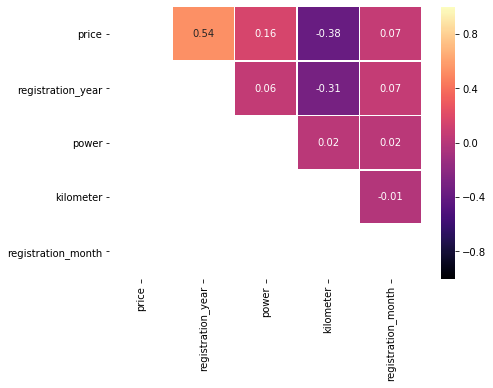

In [49]:
mask = np.tril(autos.corr())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
sns.heatmap(autos.corr(), linewidth=.5, annot=True, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='magma', linecolor='white', mask=mask, ax=ax)
plt.show()

Рассмотрим подробнее распределения у price, registration_year, power, kilometer, registration_month.

In [93]:
quant_columns = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

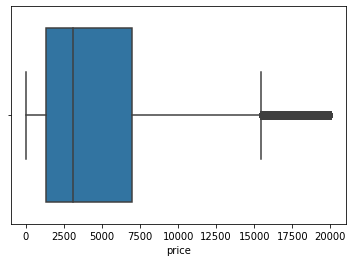

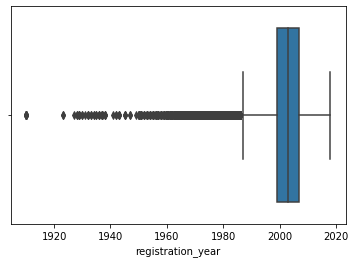

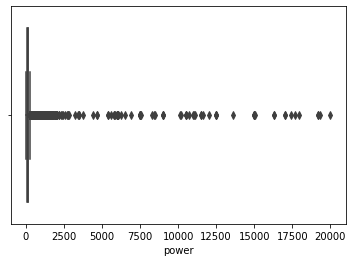

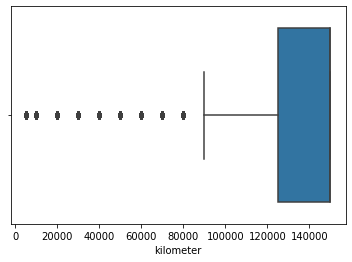

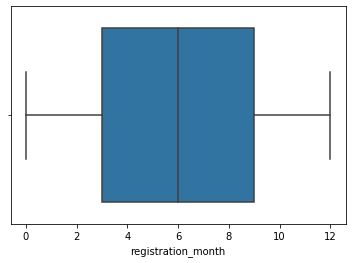

In [54]:
for column in quant_columns:
    sns.boxplot(autos[column])
    plt.show()

Признак registration_month не имеет выбросов в значениях. Ничего страшного, что kilometer содержит какие-то значения за межквартильным размахом. Могут показаться сомнительными значения power, так как если считать, что данный признак измеряется в л.с., то значения больше 5000 очень маловероятны. У самой мощной машины Devel Sixteen 5000 л.с. Также стоит посмотреть на самые ранние года в выбросах признака registration_year. Что каксается целевой переменной price, то стоит исключить объекты, цена которых меньше 1000 евро, так как по этой цене еще можно приобрести машину, а также исключим объекты, цена которых выше 15000.

In [56]:
autos.query("price > 15000")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no
179,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no
204,18400,wagon,2011,auto,313,5er,150000,11,gasoline,bmw,no
...,...,...,...,...,...,...,...,...,...,...,...
354210,17990,bus,2007,auto,174,transporter,125000,7,gasoline,volkswagen,no
354279,16500,suv,2013,manual,116,i_reihe,30000,9,gasoline,hyundai,no
354286,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes
354306,16999,wagon,2008,auto,269,a6,150000,7,gasoline,audi,no


In [60]:
autos.drop(autos.query("price > 15000 or price < 1000").index.tolist(), axis=0, inplace=True)

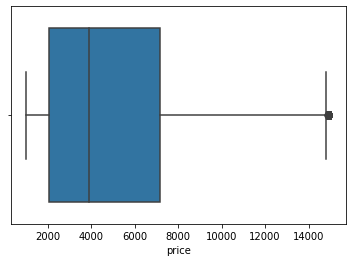

In [61]:
sns.boxplot(autos['price'])
plt.show()

In [63]:
autos.loc[autos['registration_year'] < 1940]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
23750,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,no
33638,5400,small,1937,manual,0,other,20000,3,petrol,opel,no
34055,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes
37953,9500,other,1937,manual,0,other,20000,4,petrol,ford,no
62803,3400,small,1910,manual,90,beetle,90000,4,gasoline,volkswagen,no
76529,4800,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,no
108326,14000,sedan,1936,manual,0,500,5000,1,petrol,fiat,no
117371,8750,convertible,1923,manual,11,c3,5000,0,petrol,citroen,no
122879,8000,other,1930,manual,23,other,150000,0,petrol,peugeot,no
137324,11500,convertible,1929,manual,15,other,5000,1,gasoline,bmw,yes


Серьезных выбросов в признаке года регистрации нет.

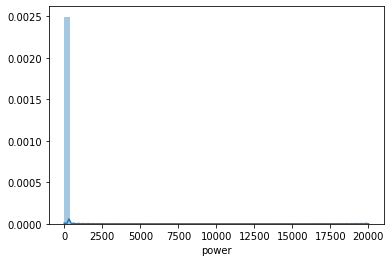

In [68]:
sns.distplot(autos['power'])
plt.show()

Удалим те объекты, мощность которых больше 1000 л.с. Уже больше являются гоночные машины такие как NISSAN GT-R, Bugatti, Hennessey, Lamborghini и др.

In [70]:
autos.drop(autos.query("power > 1000").index.tolist(), axis=0, inplace=True)

In [71]:
autos.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no


Изменим значения признака not_repaired: no - 0, yes - 1.

In [72]:
autos.loc[autos['not_repaired'] == 'no', 'not_repaired'] = 0
autos.loc[autos['not_repaired'] == 'yes', 'not_repaired'] = 1
autos['not_repaired'].unique()

array([0, 1])

In [73]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228243 entries, 2 to 354368
Data columns (total 11 columns):
price                 228243 non-null int64
vehicle_type          228243 non-null object
registration_year     228243 non-null int64
gearbox               228243 non-null object
power                 228243 non-null int64
model                 228243 non-null object
kilometer             228243 non-null int64
registration_month    228243 non-null int64
fuel_type             228243 non-null object
brand                 228243 non-null object
not_repaired          228243 non-null int64
dtypes: int64(6), object(5)
memory usage: 20.9+ MB


In [82]:
X = autos.drop('price', axis=1)
X.head(1)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0


In [83]:
y = autos['price']
y

2          9800
3          1500
4          3600
6          2200
8         14500
          ...  
354362     3200
354363     1150
354366     1199
354367     9200
354368     3400
Name: price, Length: 228243, dtype: int64

## Обучение моделей

In [95]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True)
X_train_valid.shape, X_test.shape, y_train_valid.shape, y_test.shape

((182594, 10), (45649, 10), (182594,), (45649,))

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state=7, test_size=0.25)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((136945, 10), (45649, 10), (136945,), (45649,))

In [92]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

### LGBMRegressor

Для данного градиентного бустинга категориальные признаки необходимо кодировать с помощью Ordinal Encoding.

In [116]:
ord_enc = OrdinalEncoder()
cat_features_ord = ord_enc.fit_transform(autos[cat_features])
cat_features_ord

array([[  6.,   0., 117.,   2.,  14.],
       [  5.,   1., 116.,   6.,  37.],
       [  5.,   1., 101.,   2.,  31.],
       ...,
       [  1.,   0., 106.,   6.,  32.],
       [  0.,   1., 224.,   2.,  37.],
       [  7.,   1., 116.,   2.,  37.]])

In [117]:
cat_features_ord = pd.DataFrame(cat_features_ord, columns=cat_features)
cat_features_ord

,vehicle_type,gearbox,model,fuel_type,brand
0,6.0,0.0,117.0,2.0,14.0
1,5.0,1.0,116.0,6.0,37.0
2,5.0,1.0,101.0,2.0,31.0
3,1.0,1.0,8.0,6.0,25.0
4,0.0,1.0,60.0,6.0,10.0
...,...,...,...,...,...
228238,4.0,1.0,140.0,6.0,30.0
228239,0.0,1.0,249.0,6.0,24.0
228240,1.0,0.0,106.0,6.0,32.0
228241,0.0,1.0,224.0,2.0,37.0


In [124]:
quant_features = autos.drop(cat_features, axis=1).reset_index(drop=True)
quant_features

,price,registration_year,power,kilometer,registration_month,not_repaired
0,9800,2004,163,125000,8,0
1,1500,2001,75,150000,6,0
2,3600,2008,69,90000,7,0
3,2200,2004,109,150000,8,0
4,14500,2014,125,30000,8,0
...,...,...,...,...,...,...
228238,3200,2004,225,150000,5,1
228239,1150,2000,0,150000,3,0
228240,1199,2000,101,125000,3,0
228241,9200,1996,102,150000,3,0


In [125]:
autos_ord = quant_features.merge(cat_features_ord, left_index=True, right_index=True)
autos_ord.head(5)

,price,registration_year,power,kilometer,registration_month,not_repaired,vehicle_type,gearbox,model,fuel_type,brand
0,9800,2004,163,125000,8,0,6.0,0.0,117.0,2.0,14.0
1,1500,2001,75,150000,6,0,5.0,1.0,116.0,6.0,37.0
2,3600,2008,69,90000,7,0,5.0,1.0,101.0,2.0,31.0
3,2200,2004,109,150000,8,0,1.0,1.0,8.0,6.0,25.0
4,14500,2014,125,30000,8,0,0.0,1.0,60.0,6.0,10.0


In [126]:
autos_ord.shape[0]

228243

In [127]:
Xo = autos_ord.drop('price', axis=1)
yo = autos_ord['price']

In [128]:
Xo_train_valid, Xo_test, yo_train_valid, yo_test = train_test_split(Xo, yo, test_size=0.2, random_state=7, shuffle=True)
Xo_train_valid.shape, Xo_test.shape, yo_train_valid.shape, yo_test.shape

((182594, 10), (45649, 10), (182594,), (45649,))

In [129]:
Xo_train, Xo_valid, yo_train, yo_valid = train_test_split(Xo_train_valid, yo_train_valid, random_state=7, test_size=0.25)
Xo_train.shape, Xo_valid.shape, yo_train.shape, yo_valid.shape

((136945, 10), (45649, 10), (136945,), (45649,))

In [130]:
estimators = list(range(200, 1800, 250))
depths = list(range(6, 12, 1))
learning_rates = [0.01, 0.05, 0.1, 0.2]

In [133]:
rmse_estimator = []
rmse_depth = []
rmse_learning_rate = []

for estimator in estimators:
    model = LGBMRegressor(n_estimators=estimator, random_state=7)
    model.fit(Xo_train, yo_train)
    y_pred = model.predict(Xo_valid)
    rmse_estimator.append(np.sqrt(mean_squared_error(yo_valid, y_pred)))

for depth in depths:
    model = LGBMRegressor(max_depth=depth, random_state=7)
    model.fit(Xo_train, yo_train)
    y_pred = model.predict(Xo_valid)
    rmse_depth.append(np.sqrt(mean_squared_error(yo_valid, y_pred)))

for rate in learning_rates:
    model = LGBMRegressor(learning_rate=rate, random_state=7)
    model.fit(Xo_train, yo_train)
    y_pred = model.predict(Xo_valid)
    rmse_learning_rate.append(np.sqrt(mean_squared_error(yo_valid, y_pred)))

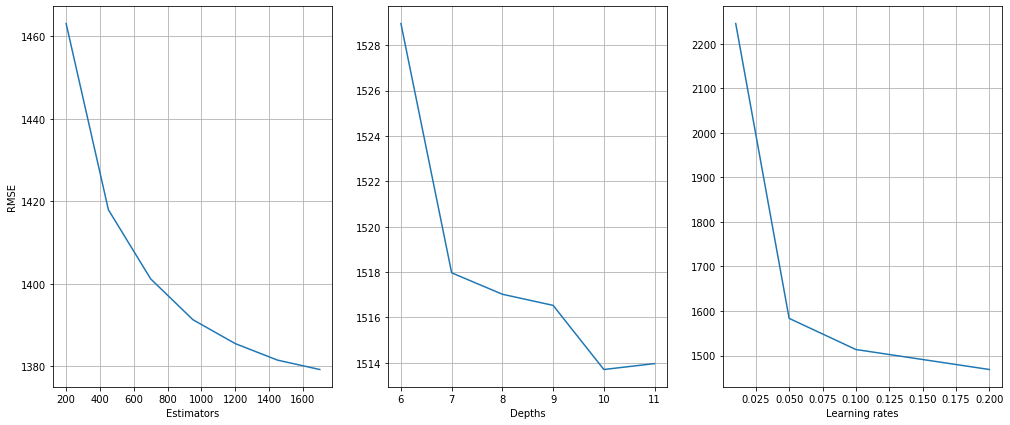

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

sns.lineplot(x=estimators, y=rmse_estimator, ax=ax[0])
sns.lineplot(x=depths, y=rmse_depth, ax=ax[1])
sns.lineplot(x=learning_rates, y=rmse_learning_rate, ax=ax[2])

ax[2].set_xlabel('Learning rates')        
ax[1].set_xlabel('Depths')
ax[0].set_xlabel('Estimators')
ax[0].set_ylabel('RMSE')
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

Видим тренд снижения RMSE с увеличением значений трех гиперпараметров. Оптимальным значением max_depth=10, а значения n_estimators и learning_rate при построении модели можно взять больше, например:
- n_estimators=2000
- max_depth=10

In [136]:
%%time
lgbmr = LGBMRegressor(n_estimators=2000, max_depth=10, learning_rate=0.25)
lgbmr.fit(Xo_train, yo_train)

CPU times: user 1min 11s, sys: 0 ns, total: 1min 11s
Wall time: 1min 11s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.25, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [138]:
%%time
y_pred = lgbmr.predict(Xo_test)

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


In [139]:
print(f'RMSE на модели LGBMRegressor: {np.sqrt(mean_squared_error(yo_test, y_pred))}')

RMSE на модели LGBMRegressor: 1409.8426554391929


### CatBoostRegressor

In [97]:
estimators = list(range(50, 1500, 150))
depths = list(range(3, 10, 1))
learning_rates = [0.01, 0.05, 0.1, 0.2]

In [99]:
rmse_estimator = []
rmse_depth = []
rmse_learning_rate = []

for estimator in estimators:
    model = CatBoostRegressor(n_estimators=estimator, random_state=7)
    model.fit(X_train, y_train, cat_features=cat_features, verbose=10)
    y_pred = model.predict(X_valid)
    rmse_estimator.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

for depth in depths:
    model = CatBoostRegressor(max_depth=depth, random_state=7)
    model.fit(X_train, y_train, cat_features=cat_features, verbose=10)
    y_pred = model.predict(X_valid)
    rmse_depth.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

for rate in learning_rates:
    model = CatBoostRegressor(learning_rate=rate, random_state=7)
    model.fit(X_train, y_train, cat_features=cat_features, verbose=10)
    y_pred = model.predict(X_valid)
    rmse_learning_rate.append(np.sqrt(mean_squared_error(y_valid, y_pred)))

0:	learn: 3559.8829891	total: 172ms	remaining: 8.44s
10:	learn: 3020.4309512	total: 2.27s	remaining: 8.04s
20:	learn: 2653.7268545	total: 4.26s	remaining: 5.89s
30:	learn: 2395.3681041	total: 6.26s	remaining: 3.84s
40:	learn: 2201.6190938	total: 8.25s	remaining: 1.81s
49:	learn: 2073.0037128	total: 10s	remaining: 0us
0:	learn: 3560.2939099	total: 322ms	remaining: 1m 4s
10:	learn: 3013.9472821	total: 4.41s	remaining: 1m 15s
20:	learn: 2630.4925841	total: 8.4s	remaining: 1m 11s
30:	learn: 2363.8509807	total: 12.5s	remaining: 1m 8s
40:	learn: 2177.5888383	total: 16.3s	remaining: 1m 3s
50:	learn: 2045.0437302	total: 20.2s	remaining: 59s
60:	learn: 1944.1688768	total: 24.2s	remaining: 55.1s
70:	learn: 1868.7704727	total: 27.9s	remaining: 50.6s
80:	learn: 1815.0291793	total: 31.2s	remaining: 45.8s
90:	learn: 1774.2021171	total: 34.9s	remaining: 41.7s
100:	learn: 1744.1500899	total: 38.7s	remaining: 38s
110:	learn: 1719.5572449	total: 43.1s	remaining: 34.6s
120:	learn: 1699.2358410	total: 47.

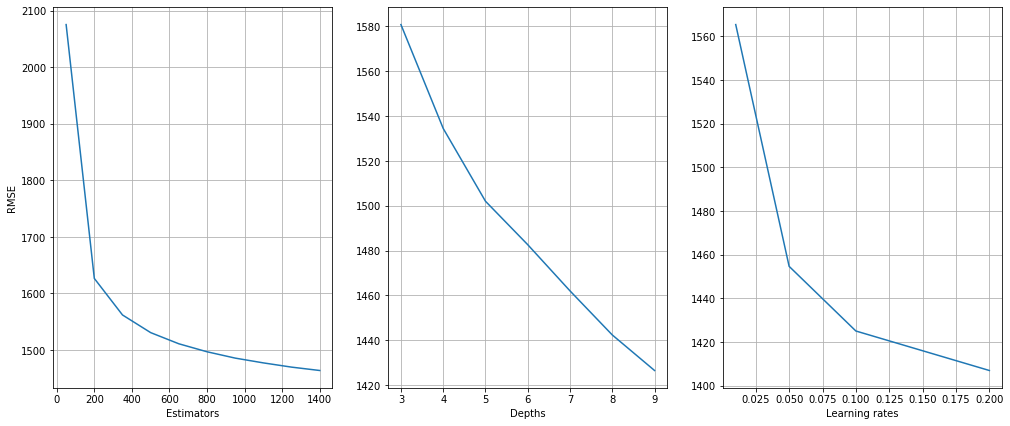

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

sns.lineplot(x=estimators, y=rmse_estimator, ax=ax[0])
sns.lineplot(x=depths, y=rmse_depth, ax=ax[1])
sns.lineplot(x=learning_rates, y=rmse_learning_rate, ax=ax[2])

ax[2].set_xlabel('Learning rates')        
ax[1].set_xlabel('Depths')
ax[0].set_xlabel('Estimators')
ax[0].set_ylabel('RMSE')
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

Видим тренд по всем трем гиперпараметрам, что с увеличением n_estimators, max_depth и learning_rate RMSE снижается, поэтому при построении модели возьмем большие значения данных гиперпараметров такие как:
- n_estimators=1600
- max_depth=11,
- learning_rate=0.25

In [105]:
%%time
cbr = CatBoostRegressor(n_estimators=1600, max_depth=11, learning_rate=0.25)
cbr.fit(X_train, y_train, cat_features=cat_features, verbose=10)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs
0:	learn: 3020.5929710	total: 991ms	remaining: 26m 24s
10:	learn: 1595.4261069	total: 9.28s	remaining: 22m 20s
20:	learn: 1488.1660911	total: 18s	remaining: 22m 31s
30:	learn: 1438.2160051	total: 26.9s	remaining: 22m 39s
40:	learn: 1405.4059142	total: 35.7s	remaining: 22m 35s
50:	learn: 1381.0786669	total: 44.3s	remaining: 22m 26s
60:	learn: 1361.6436244	total: 53s	remaining: 22m 18s
70:	learn: 1344.4641711	total: 1m 2s	remaining: 22m 15s
80:	learn: 1331.3678754	total: 1m 11s	remaining: 22m 13s
90:	learn: 1317.5242003	total: 1m 20s	remaining: 22m 13s
100:	learn: 1304.9061609	total: 1m 29s	remaining: 22m 9s
110:	learn: 1293.5365926	total: 1m 38s	remaining: 22m 5s
120:	learn: 1277.6793219	total: 1m 48s	remaining: 22m 2s
130:	learn: 1265.8377870	total: 1m 57s	remaining: 21m 55s
140:	learn: 1258.7198423	total: 2m 6s	remaining: 21m 46s
150:	learn: 1245.6589620	total: 2m 15s	remaining: 21m 41s
160:	learn: 1239.2827175	total:

In [111]:
%%time
y_pred = cbr.predict(X_test)

CPU times: user 3.56 s, sys: 0 ns, total: 3.56 s
Wall time: 3.54 s


In [108]:
print(f'RMSE на модели CatBoostRegressor: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE на модели CatBoostRegressor: 1403.4846841730803


## Анализ моделей

Рассмотрев модели LGBMRegressor и CatBoostRegressor, можно сделать следующие выводы:
1. Скорость обучения: наиболее быстрой моделью оказалась модель LGBMRegressor, которая провела обучение за чуть больше 1 минуты в то время, как вторая модель за примерно 25 минут (возможно это связано с тем, что в первом случае категориальные признаки прошли через OrdinalEncoder);
2. Скорость предсказания: здесь же быстрой оказалась модель CatBoostRegressor, которая вывела ответа за 3.5 секунды в то время, как первая модель за 10 секунд;
3. Качество предсказания: качество моделей примерно одинаковое, но модель CatBoostRegressor оказалась немного да точнее с RMSE, равным 1403 (это значит, что в среднем ответы отклоняются от реальных на 1403 евро), а LGBMRegressor - 1409.